In [5]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, requests, json
from IPython.display import clear_output as co

In [6]:
class data:

    path = r'C:\Users\luisr\Desktop\Repositories\Dados\Desafio COR-Rio IV\\'
    AlertaAPI = r'http://websempre.rio.rj.gov.br/json/chuvas'

    def load_csv_folder(path):
        files = os.listdir(path)
        dfs = {}
        for i, file in enumerate(files):
            name, ext = file.split('.')
            dfs[name] = (pd.read_csv(path+file) if ext=='csv' else pd.read_excel(path+file))
            print(f'{i+1}/{len(files)} files loaded.'); co(wait=True)
        return dfs

def get_alert():
    readings = ['m05', 'm15', 'mes', 'h96', 'h24', 'h03', 'h02', 'h01', 'h04']
    alertas = pd.DataFrame(json.loads(requests.get(data.AlertaAPI).text)['objects'])
    alertas[readings] = pd.DataFrame(dict(alertas['data'])).T
    return alertas.drop('data', 1)

Relevantes na ordem:
1. Eventos Mapeados
2. Meteorologia INMET
3. Estações_Meteorológicas_INMET
4. API Alertas Rio
3. Dados Extração Comando
5. Mudança de Estágios 2016-2022
4. Logradouros
5. Edificações 2013

In [19]:
files = os.listdir(data.path); files # arquivos

['comando.csv',
 'Dados_Extração_Comando.xlsx',
 'Edificações_2013.csv',
 'Estações_Meteorológicas_INMET.csv',
 'Estações_Pluviométricas_AlertaRio.csv',
 'Eventos_Mapeados.csv',
 'Hidrografia.csv',
 'Limite_Favelas_2019.csv',
 'Logradouros.csv',
 'Meteorologia_INMET.csv',
 'Mudança de Estágios 2016_2022.xlsx',
 'Sub_Bacias_Hidrograficas.csv']

### Carregando tabelas

In [4]:
# dfs = data.load_csv_folder(data.path)

### Requisição do alerta rio em tempo real

In [5]:
alertas = get_alert(); alertas.head()

,kind,read_at,name,is_new,location,m05,m15,mes,h96,h24,h03,h02,h01,h04
0,pluviometric,2022-08-04T00:20:00-03:00,Vidigal,True,"[-22.9925, -43.233056]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,pluviometric,2022-08-04T00:20:00-03:00,Urca,True,"[-22.955833, -43.166667]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,pluviometric,2022-08-04T00:20:00-03:00,Rocinha,True,"[-22.985833, -43.245]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,pluviometric,2022-08-04T00:20:00-03:00,Tijuca,True,"[-22.931944, -43.221667]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,pluviometric,2022-08-04T00:20:00-03:00,Santa Teresa,True,"[-22.931667, -43.196389]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Imprimindo tabelas para conferir

In [ ]:
for i, key in enumerate(dfs.keys()):
    df = dfs[key]
    print(f'\n\nTABELA {i+1} - {key}')
    print(f'Tamanho: {df.shape}')
    print('\n')
    display(df.head())

### Tabela comando e eventos

In [116]:
comando, eventos = ( pd.read_csv(data.path + file) for file in ['comando.csv', 'Eventos.csv'] )


c:\Users\luisr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (4,10) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Geocodificando endereços de eventos com api do google maps

In [85]:
import googlemaps
gmaps = googlemaps.Client(key=open('GoogleApiKey.txt', 'r').read()) # load google api key

def geocode_addresses(addresses, path=None):
    locations = []
    for i, address in enumerate(addresses):
        result = pd.DataFrame(gmaps.geocode(address))
        result['search_address'] = address
        locations.append(result)
        print(f'{i+1}/{len(addresses)} locations geocoded.'); co(wait=True)
    if path is not None:
        locations.to_csv(path, index=False)
    return pd.concat(locations, 0).reset_index(drop=True)

# locations =  geocode_addresses(eventos['ENDEREÇO'].unique()) # retrieve locations

In [118]:
locations = pd.read_csv('eventos_loc.csv')

def event_location_map(address):
    try:
        return json.loads(locations[locations['search_address']==address]['geometry'].iloc[0].replace("'", '"'))['location']
    except:
        return np.nan

eventos['COORDS'] = list(map(event_location_map, eventos['ENDEREÇO']))

### Conferindo resultado da geocodificação

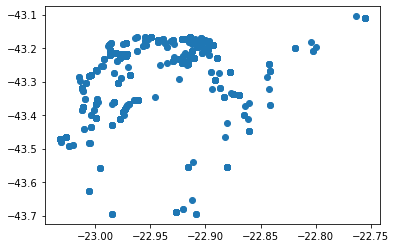

In [163]:
coords = pd.DataFrame(eventos['COORDS'].dropna().to_list())

plt.scatter(coords['lat'], coords['lng'])

In [166]:
eventos['ENDEREÇO'].value_counts()

Av. Infante Dom Henrique, S/N - Glória, Rio de Janeiro - RJ, 20021-140                          157
Av. Pres. Castelo Branco, Portão 3 - Maracanã, Rio de Janeiro - RJ, 20271-130                   149
Av. Rodrigues Alves, 299 - Gambôa, Rio de Janeiro - RJ, 20220-350                                96
Av. Salvador Allende, 6555 - Barra da Tijuca, Rio de Janeiro - RJ, 22783-127                     70
Av. Infante Dom Henrique, 85 - Parque do Flamengo, Rio de Janeiro - RJ, 20021-140                70
                                                                                               ... 
Estrada Padre Roser, 936 - Vila da Penha, Rio de Janeiro - RJ, 21220-560                          1
Viaduto Pref. Negrão de Lima - Madureira                                                          1
Avenida General Osvaldo Cordeiro De Farias - Marechal Hermes, Rio de Janeiro - RJ, 21610-480      1
R. Orestes, 28 - Santo Cristo, Rio de Janeiro - RJ, 20220-070                                     1


In [167]:
comando

,EVENTO_ID,EVENTO_TITULO,EVENTO_DESCRICAO,EVENTO_GRAVIDADE,EVENTO_BAIRRO,STATUS,EVENTO_INICIO,EVENTO_INICIO_HORA,EVENTO_FIM,EVENTO_FIM_HORA,EVENTO_PRAZO,EVENTO_LATITUDE,EVENTO_LONGITUDE,POP_TITULO,POP_DESCRICAO,ORGAO_SIGLA,ORGAO_NOME,ACAO
0,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23,12:13:00,2015-02-23,14:18:00,NaN,0.000000,0.00000,Acidente com vítima(s),Acidente com vítima(s),CET-RIO,Companhia de Engenharia de Tráfego,Desfazer o acidente
1,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23,12:13:00,2015-02-23,14:18:00,NaN,NaN,0.00000,Acidente com vítima(s),Acidente com vítima(s),CET-RIO,Companhia de Engenharia de Tráfego,Organizar o trânsito
2,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23,12:13:00,2015-02-23,14:18:00,NaN,0.000000,0.00000,Acidente com vítima(s),Acidente com vítima(s),BOMBEIROS,Corpo de Bombeiros,Atender vítima(s)
3,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23,12:13:00,2015-02-23,14:18:00,NaN,0.000000,0.00000,Acidente com vítima(s),Acidente com vítima(s),BOMBEIROS,Corpo de Bombeiros,Prevenir perigo
4,2,"Ac mt e tx, na LVermelha, sent Centro, altura ...","Ac mt e tx, na LVermelha, sent Centro, altura ...",BAIXO,NaN,FECHADO,2015-02-23,12:13:00,2015-02-23,14:18:00,NaN,0.000000,0.00000,Acidente com vítima(s),Acidente com vítima(s),PM,Polícia Militar,Registrar o acidente
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205136,73894,Enguiço CM,Túnel Rebouças - 1a Galeria - Sent. Centro,BAIXO,Santa Teresa,FECHADO,2022-05-02,10:03:00,2022-05-02,11:30:00,CURTO,-22.946882,-43.20316,Acidente/enguiço sem vítima,Acidente ou enguiço envolvendo veículo(s) pequ...,CET-RIO,Companhia de Engenharia de Tráfego,Desfazer o acidente
205137,73894,Enguiço CM,Túnel Rebouças - 1a Galeria - Sent. Centro,BAIXO,Santa Teresa,FECHADO,2022-05-02,10:03:00,2022-05-02,11:30:00,CURTO,-22.946882,-43.20316,Acidente/enguiço sem vítima,Acidente ou enguiço envolvendo veículo(s) pequ...,CET-RIO,Companhia de Engenharia de Tráfego,Organizar o trânsito
205138,73895,AC envol. VP,Av. das Américas - Alt. Viaduto Orlando Raso -...,BAIXO,Recreio dos Bandeirantes,FECHADO,2022-05-02,10:55:00,2022-05-02,12:08:00,CURTO,-23.017588,-43.48061,Acidente/enguiço sem vítima,Acidente ou enguiço envolvendo veículo(s) pequ...,CET-RIO,Companhia de Engenharia de Tráfego,Desfazer o acidente
205139,73895,AC envol. VP,Av. das Américas - Alt. Viaduto Orlando Raso -...,BAIXO,Recreio dos Bandeirantes,FECHADO,2022-05-02,10:55:00,2022-05-02,12:08:00,CURTO,-23.017588,-43.48061,Acidente/enguiço sem vítima,Acidente ou enguiço envolvendo veículo(s) pequ...,CET-RIO,Companhia de Engenharia de Tráfego,Organizar o trânsito
